In [244]:
# import
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import gym
from collections import namedtuple
import torch.optim as optim
import random
import matplotlib.pyplot as plt

In [245]:
# hyper-params
GAMMA = .9
LEARNING_RATE = .001
EXPERIENCE_CAPACITY = 1000
UPDATE_FREQUENCY = 10
MAX_EPI = 200
MAX_STEP = 200
BATCH_SIZE = 30
EPSILON = .1
N_STATES = 4
N_ACTIONS = 2

In [246]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [247]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        N_STATES = 4
        N_ACTIONS = 2
        self.fc1 = nn.Linear(N_STATES, 10)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(10, N_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [264]:
# functions
def choose_action(bahavior_network, o):
    if random.random()<EPSILON:
        return random.randint(0, N_ACTIONS-1)
    else:
        action = behavior_network(Variable(Tensor(o).unsqueeze(0))).max(1)[1]
        return action.data[0][0]

def mse_loss(input, target):
    return torch.sum((input - target)**2) / input.data.nelement()
        
def run_and_store(env, behavior_network, exp):
    o = env.reset()
    count = 0
    for t in xrange(MAX_STEP):
        count += 1
        a = choose_action(behavior_network, o)
        o_next, r, done, info = env.step(a)
        
        
        x, x_dot, theta, theta_dot = o_next
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2
        
        
        
        exp.push(o, a, r, o_next)
        o = o_next
        if done:
            break
    return count
            
def learn(target_network, behavior_network, exp, optimizer):
    # batch
    minibatch = exp.sample(BATCH_SIZE)
    minibatch = Transition(*zip(*minibatch))
    s_batch = Variable(Tensor(minibatch.state))
    a_batch = Variable(LongTensor(minibatch.action).unsqueeze(1))
    r_batch = Variable(Tensor(minibatch.reward))
    s_next_batch = Variable(Tensor(minibatch.next_state))

    # loss
    s_eval = behavior_network(s_batch).gather(1, a_batch)
    s_next_eval = target_network(s_next_batch).max(1)[0]
    Gt = r_batch + GAMMA * s_next_eval
    Gt.detach_()
    criterion = nn.MSELoss().cuda()
    if use_cuda:
        criterion.cuda()
    loss = criterion(s_eval, Gt)
    #loss = mse_loss(s_eval, Gt)
    
    # SGD
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
def update_param(target_network, behavior_network):
    target_network.load_state_dict(behavior_network.state_dict())

[2017-07-27 22:28:28,250] Making new env: CartPole-v0


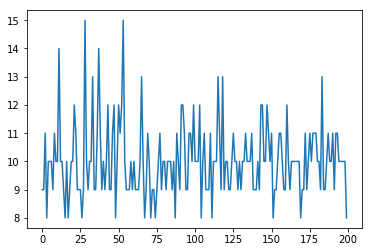

In [266]:
# main
env = gym.make('CartPole-v0')
env = env.unwrapped
behavior_network = DQN()
target_network = DQN()
if use_cuda:
    behavior_network.cuda()
    target_network.cuda()
exp = Experience(EXPERIENCE_CAPACITY)
optimizer = optim.SGD(behavior_network.parameters(), lr=LEARNING_RATE)
steps = []
for epi in xrange(MAX_EPI):
    #if epi%200==199:
    #    print epi
    # run epi under behavior network and store experience in exp
    step = run_and_store(env, behavior_network, exp)
    steps.append(step)
    # update behavior network
    learn(target_network, behavior_network, exp, optimizer)
    # update target network every UPDATE_FREQUENCY step
    if(epi%UPDATE_FREQUENCY==UPDATE_FREQUENCY-1):
        update_param(target_network, behavior_network)
plt.plot(xrange(MAX_EPI), steps)
plt.show()

In [259]:
s = Variable(Tensor([1,2,3,4])).unsqueeze(0)
print s
print behavior_network.cuda()(s)

Variable containing:
 1  2  3  4
[torch.cuda.FloatTensor of size 1x4 (GPU 0)]

Variable containing:
-0.1739  0.2354
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]



In [200]:
x = Variable(Tensor([1,2,3]), requires_grad=True)
y = Variable(Tensor([4,5,6]), requires_grad=False)
criterion = nn.MSELoss()
loss = criterion(x,y)
loss.backward()
#print loss
x = 1
print x++

SyntaxError: invalid syntax (<ipython-input-200-d4b0cd86402f>, line 8)